In [1]:
# from scratch implementation with variables
import torch
import torch.nn.functional as F

In [2]:
words = open("../data/names.txt", "r").read().splitlines()

In [3]:
len(words)

32033

In [4]:
vocab_size = 27

# hyperparameters
# number of input tokens to predict next token
block_size = 8

# splitting intro training, validation and test sets
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# embedding dimensions
n_embed = 10
batch_size = 32

# num neurons
n_hidden = 68

training_iterations = 200000


In [5]:
# stoi and itos mapping
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Main idea: convert into examples
Examples are triplets of words

Starting from `[0] * block_size` and then adding an ending character at the back

In [6]:
def build_dataset(words: list[str]):
    X, Y = [], []
    for word in words:
        context = [0] * block_size
        chs = word + "."
        for ch in chs:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [7]:
import random

random.seed(42)
random.shuffle(words)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

Main idea: set up the model weights

We have the embedding layer, the hidden layer and the output layer

In [8]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)

W1 = (
    torch.randn((block_size * n_embed, n_hidden), generator=g)
    * (5 / 3)
    / (n_embed * block_size**0.5)
)
# b1 = torch.randn((n_hidden), generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0

# batch norm
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

In [9]:
stepi = []
lossi = []

In [10]:
# torchifying our code
from torch import Tensor


class Linear:
    def __init__(self, fan_in: int, fan_out: int, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros((fan_out)) if bias else None

    def __call__(self, x: Tensor):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self) -> list[Tensor]:
        if self.bias is not None:
            return [self.weight, self.bias]
        return [self.weight]


class BatchNorm1d:
    # assume affine True (will be using gamma and beta)
    # track running stats is true
    def __init__(self, dim: int, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters
        # the bngain and bnbias
        self.gamma = torch.ones(dim)  # initially scale as 1
        self.beta = torch.zeros(dim)  # initially no shift

        # buffers (trained with running momentum update)
        self.running_mean = torch.zeros(dim)  # initially for normal distr mean is 0
        self.running_var = torch.ones(dim)  # initially for normal distri var is 1

    def __call__(self, x):
        # forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            else:
                raise ValueError(f"Expected 2 or 3 dimensional input, got {x.ndim}.")

            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # not in pytorch - just to make it easier to calculate statistics
        self.out = self.gamma * xhat + self.beta

        if self.training:
            # exponential weighted average
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


# activation layer
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:
    def __init__(self, vocab_size: int, embedding_dim: int):
        self.weight = torch.randn((vocab_size, embedding_dim), generator=g)

    def __call__(self, IX: Tensor):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]


class FlattenConsecutive:
    # n is the number of consecutive elements to concatenate
    def __init__(self, n):
        self.n = n

    def __call__(self, x: Tensor):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)

        # if x is 1, just return 2 dimensional tensor like before
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.out = x
        return self.out

    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]


model = Sequential(
    [
        Embedding(vocab_size, n_embed),
        FlattenConsecutive(2),
        Linear(n_embed * 2, n_hidden),
        BatchNorm1d(n_hidden),
        Tanh(),

        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden),
        BatchNorm1d(n_hidden),
        Tanh(),

        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden),
        BatchNorm1d(n_hidden),
        Tanh(),

        Linear(n_hidden, vocab_size),
    ]
)

with torch.no_grad():
    # last layer make less confident
    # layers[-1].weight *= 0.1
    model.layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22601


In [11]:
max_steps = 200000
lossi = []

for i in range(max_steps):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for layer in model.layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None

    loss.backward()

    # update gradients
    lr = 0.1 if i < max_steps / 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())

    # remove after debug
    # if i > 1000:
    #     break


      0/ 200000: 3.295238
  10000/ 200000: 2.004529
  20000/ 200000: 2.597385
  30000/ 200000: 2.123443
  40000/ 200000: 1.768384
  50000/ 200000: 2.164985
  60000/ 200000: 2.268075
  70000/ 200000: 2.374428
  80000/ 200000: 2.166292
  90000/ 200000: 1.834249
 100000/ 200000: 2.073539
 110000/ 200000: 1.943927
 120000/ 200000: 1.731247
 130000/ 200000: 1.858042
 140000/ 200000: 2.089567
 150000/ 200000: 2.467682
 160000/ 200000: 2.165875
 170000/ 200000: 1.697106
 180000/ 200000: 1.883842
 190000/ 200000: 2.150454


In [12]:

for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [18]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 68])

In [19]:
torch.tensor(lossi).view(-1, 1000).mean(1).shape

torch.Size([200])

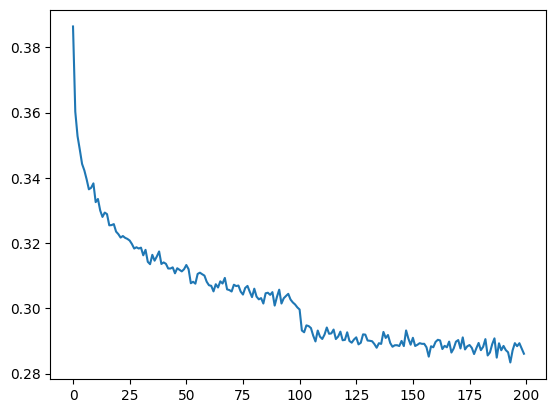

In [20]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [21]:
# put layers in eval mode
for layer in model.layers:
    layer.training = False

In [22]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)

    print(split, loss.item())


split_loss("train")
split_loss("val")

train 1.923208236694336
val 2.0203850269317627


In [17]:
# sample from the modle
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor([context]))

        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1).item()
        out.append(itos[ix])
        context = context[1:] + [ix]

        if ix == 0:
            break

    print("".join(out))


timmani.
marvayz.
callana.
eazo.
juliette.
adaylah.
alidany.
mikeyah.
abloree.
pherisha.


# Performance log

1 linear, batch, tanh sandwich

## increasing context

train 1.9310306310653687
val 2.02875018119812

## flat -> hierarchical

## fix bug in batch norm

train 1.923208236694336
val 2.0203850269317627